<a href="https://colab.research.google.com/github/martydom/Bank-Marketing-Effectiveness-Prediction/blob/main/Devashish_Bose_Team_1_Bank_Marketing_Effectiveness_Prediction_Capstone_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Predicting the effectiveness of bank marketing campaigns </u></b>

## <b> Problem Description </b>

### The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. The classification goal is to predict if the client will subscribe a term deposit (variable y).


## <b> Data Description </b>

## <b>Input variables: </b>
### <b> Bank Client data: </b>

* ### age (numeric)
* ### job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
* ### marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
* ### education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
* ### default: has credit in default? (categorical: 'no','yes','unknown')
* ### housing: has housing loan? (categorical: 'no','yes','unknown')
* ### loan: has personal loan? (categorical: 'no','yes','unknown')

### <b> Related with the last contact of the current campaign:</b>
* ### contact: contact communication type (categorical: 'cellular','telephone')
* ### month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
* ### day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
* ### duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

### <b>Other attributes: </b>
* ### campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* ### pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
* ### previous: number of contacts performed before this campaign and for this client (numeric)
* ### poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

### <b> Social and economic context attributes </b>
* ### emp.var.rate: employment variation rate - quarterly indicator (numeric)
* ### cons.price.idx: consumer price index - monthly indicator (numeric)
* ### cons.conf.idx: consumer confidence index - monthly indicator (numeric)
* ### euribor3m: euribor 3 month rate - daily indicator (numeric)
* ### nr.employed: number of employees - quarterly indicator (numeric)

### <b>Output variable (desired target):</b>
* ### y - has the client subscribed a term deposit? (binary: 'yes','no')

# **Import and Declaring helping functions**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title General Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(rc={'figure.figsize':(10,6)})
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# @title Class for Storing Fitted Models
import pickle
class save_model:
  def __init__ (self,filepath):
    self.filepath = filepath

  def load(self,name = None):
    '''
    Name : if you know the name you can extract the exact model, else you can give a specific name to extract that model.
    '''
    model_file = open(self.filepath,'rb')
    try:
      models =  pickle.load(model_file)
    except:
      model_file = {}
    model_file.close()
    if name:
      return models[name]
    else:
      return models
    

  def save(self,model,name):
    try:
      models = self.load()
    except:
      models = {}
    models[name] = model
    model_file = open(self.filepath,'wb')
    pickle.dump(models,model_file)
    model_file.close()
    return f'Dumped Model {name}'
    
  def delete(self,name):
    try:
      models = self.load()
    except:
      return f'No Models in dump'
    try:
      models.pop(name)
    except:
      return f"ENTER A VALID NAME"
    model_file = open(self.filepath,'wb')
    pickle.dump(models,model_file)
    model_file.close()
    return f'{name} Deleted'

sm = save_model('/content/drive/MyDrive/AlmaBetter/Module 4/Week 2/model_dump_self')

In [ ]:
# @title Function for plotting the counts of Categorical Variables
# plot categorical data
import seaborn as sns
import matplotlib.pyplot as plt
def plot_cat_data(df,dep_var):
  cat_columns = list(set(df.describe().columns)^set(df.columns))
  if type(df[dep_var][0])== str:
    cat_columns.remove(dep_var)
  for i,e in enumerate(cat_columns):
    plt.figure(i)
    ax = sns.countplot(df[e],hue=df[dep_var])
    for p in ax.patches:
      height = p.get_height()
      ax.text(p.get_x()+p.get_width()/2.,
              height + 3,
              '{:1.2f}'.format(height/df.shape[0]),
              ha="center")
    if(len(ax.patches)>10):
      plt.xticks(rotation=90)  
    plt.title(f'Count Plot for {e}')
    plt.show()

In [ ]:
# @title one hot encode categorical columns
# assumes you hae imported pandas
def oh_encode_cat(df,dep_var):
  cat_vars =  list(set(df.describe().columns)^set(df.columns))
  cat_vars.remove(dep_var)
  data = pd.DataFrame()
  for col in cat_vars:
    data = pd.concat([data,pd.get_dummies(df[col],prefix=col)],axis=1)
  return data

In [ ]:
# @title importing data in a readable format
dataset = pd.read_csv('/content/drive/MyDrive/AlmaBetter/Module 4/Week 2/bank-full.csv')
extract = (lambda x : [c.replace('"','').replace('"','') for c in x.split(';')])
cols = extract(dataset.columns[0])
data = dataset.iloc[:,0].apply(extract)
# Converting Data To Numeric
def convert_numeric(dat):
  new_samples=[]
  for sample in dat:
    for i,feature in enumerate(sample):
      try:
        sample[i] = int(feature)
      except:
        continue
    new_samples.append(sample)
  return new_samples
data_new = convert_numeric(data.values)
df = pd.DataFrame(data=data_new,columns=cols)
del dataset,data,data_new

In [ ]:
# @title Function to do Gridsearch_CV, To be used with Load and Store Fucnction
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
import time
from sklearn.model_selection import train_test_split
def gscv(model_dict,X,y):
  '''
  Input model_dict = {model_name:[model,param_dict,scoring_]
  '''
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)
  models = {'model': [], 'train_time': [],'train_accuracy': [], 'train_precision': [], 'train_recall': [], 'train_f1_score': [], 'train_tn fp fn tp': [], 'train_auc_roc': [], 'test_accuracy': [], 'test_precision': [], 'test_recall': [], 'test_f1_score': [], 'test_tn fp fn tp': [], 'test_auc_roc': []}
  for k in model_dict.keys():
    gs_model = GridSearchCV(estimator = model_dict[k][0], param_grid= model_dict[k][1], scoring=model_dict[k][2], n_jobs= -1,cv=5,)
    training_time = time.time()
    gs_model.fit(X_train,y_train)
    training_time = time.time() - training_time
    sm.save(gs_model,k)
    models['model'].append(k)
    models['train_time'].append(training_time)
    y_pred_test = gs_model.predict(X_test)
    y_pred_train = gs_model.predict(X_train)
    models['train_accuracy'].append(accuracy_score(y_train,y_pred_train))
    models['train_precision'].append(precision_score(y_train,y_pred_train))
    models['train_recall'].append(recall_score(y_train,y_pred_train))
    models['train_f1_score'].append(f1_score(y_train,y_pred_train))
    models['train_tn fp fn tp'].append(confusion_matrix(y_train,y_pred_train).flatten())
    models['train_auc_roc'].append(roc_auc_score(y_train,y_pred_train))
    models['test_accuracy'].append(accuracy_score(y_test,y_pred_test))
    models['test_precision'].append(precision_score(y_test,y_pred_test))
    models['test_recall'].append(recall_score(y_test,y_pred_test))
    models['test_f1_score'].append(f1_score(y_test,y_pred_test))
    models['test_tn fp fn tp'].append(confusion_matrix(y_test,y_pred_test).flatten())
    models['test_auc_roc'].append(roc_auc_score(y_test,y_pred_test))
  data = pd.DataFrame(models)
  sm.save(data,"Final Result")
  return data

# **DAY1: EDA**

In [ ]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


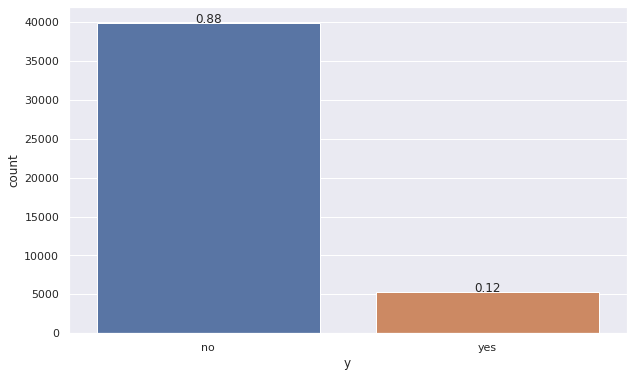

In [ ]:
ax = sns.countplot(df['y'])
for p in ax.patches:
      height = p.get_height()
      ax.text(p.get_x()+p.get_width()/2.,
              height + 3,
              '{:1.2f}'.format(height/df.shape[0]),
              ha="center")

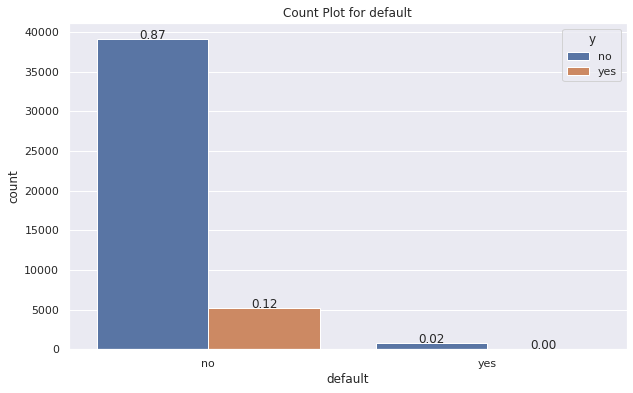

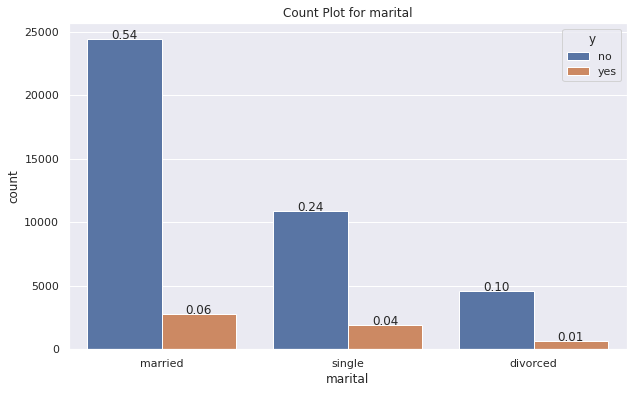

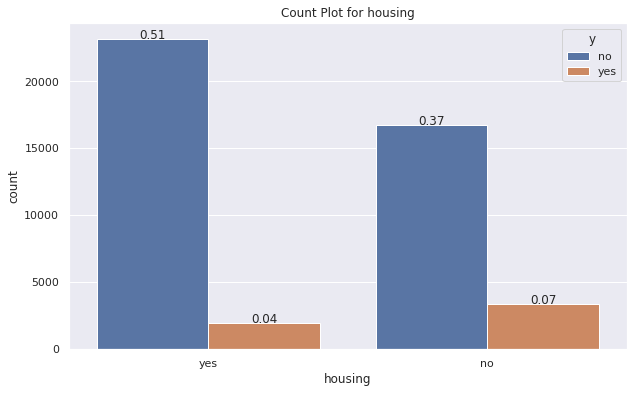

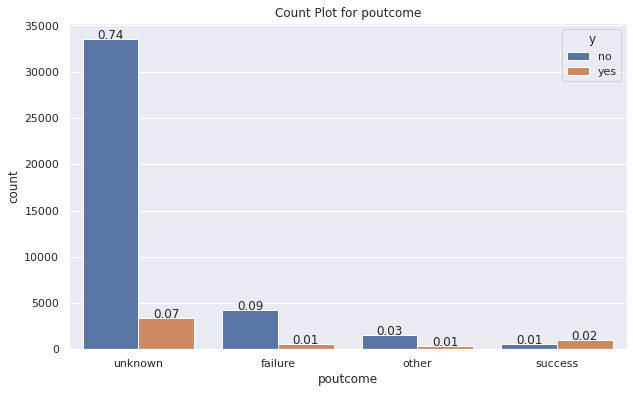

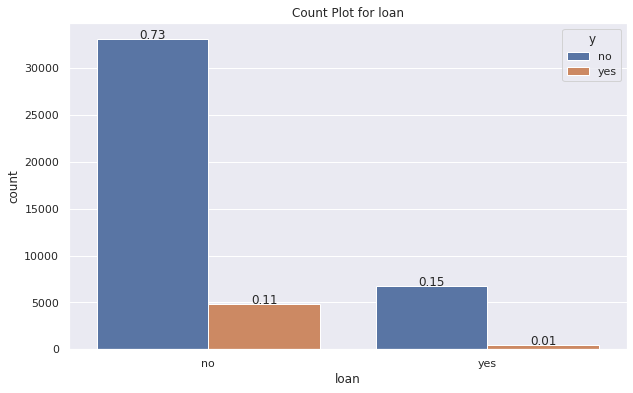

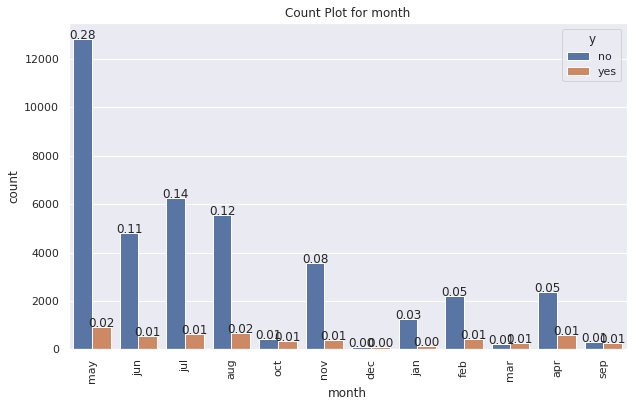

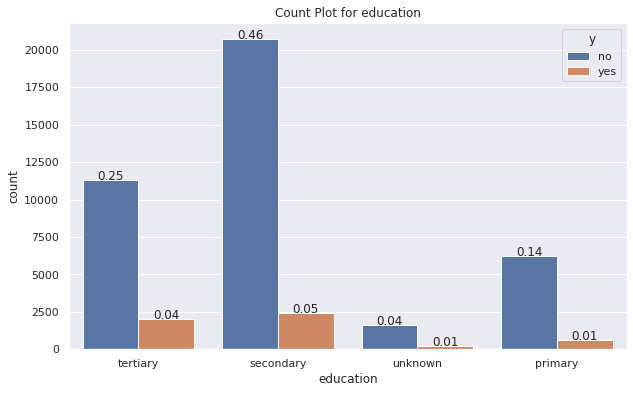

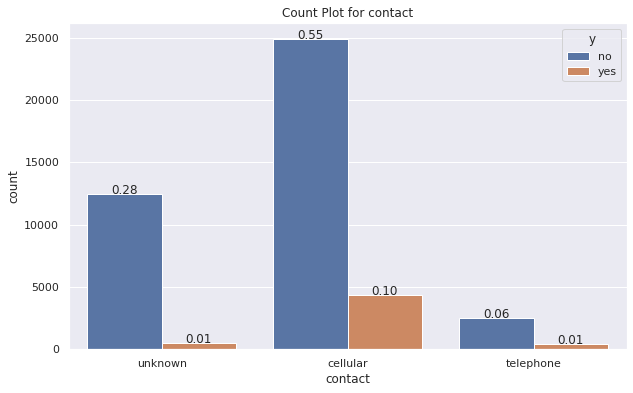

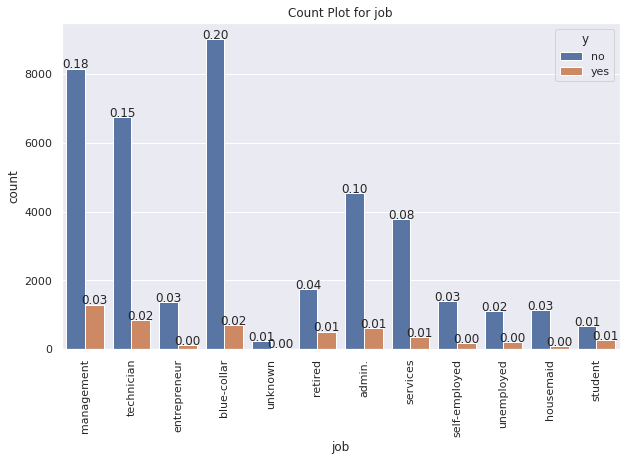

In [ ]:
plot_cat_data(df,'y')

Conclusions : 
> 1. Education is a rankwise feature where percantage of yes increases from primary >> tertiatry education
> 2. People who have housing loan are more prone to say no
> 3. There is a good chance that people who have started a term deposit before will do it again, but if they have said no earlier, there is still a chance that they will open one
>4. People who have personal loan are more prone to say no.
>5. Blue Collars reject opening a **TD** the most, whereas student and Old people buy them more.
>6. Single and married people try to save more than divorced
>7. No people who have a loan default has ever said yes
>8.Oct, mar and sep has a good ratio of acceptance/rejection
>9. People from unknown sources of contact tend to reject more

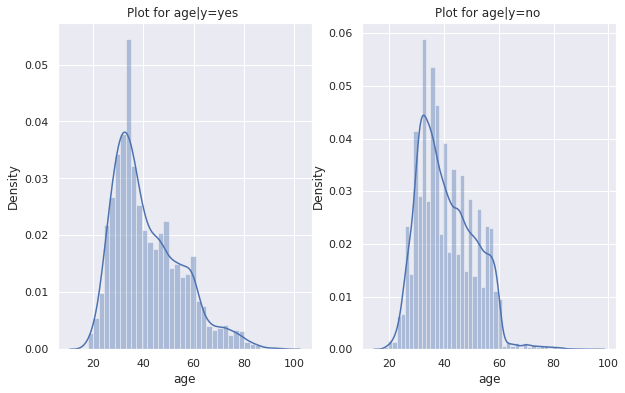

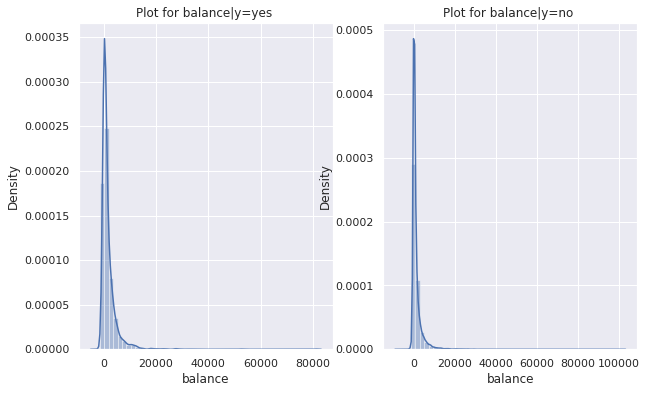

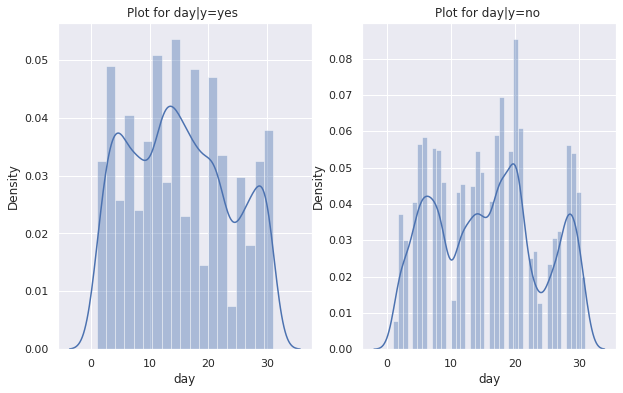

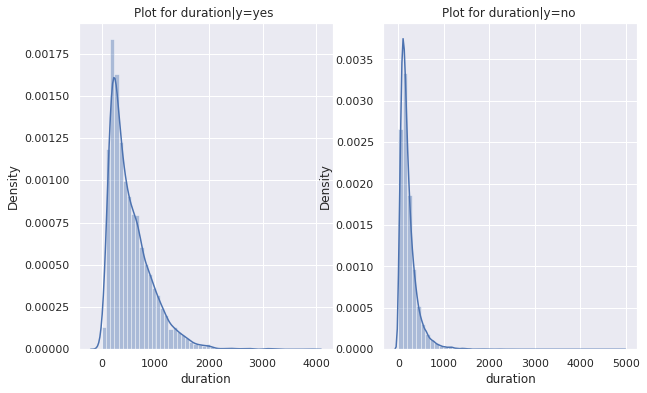

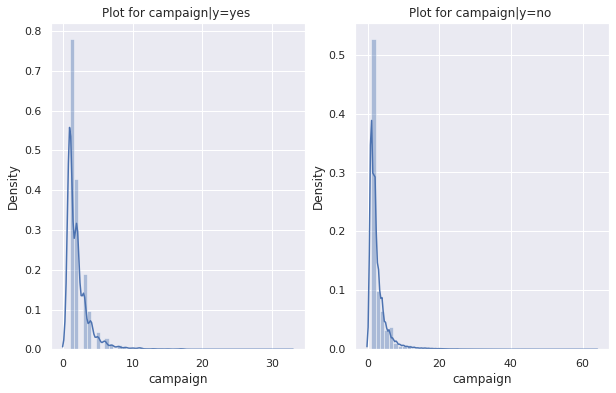

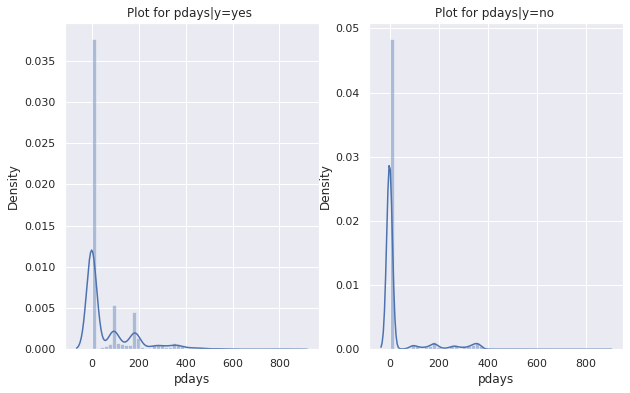

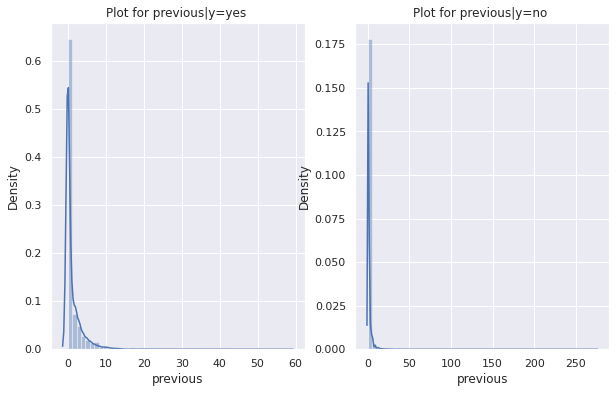

In [ ]:
for i,col in enumerate(list(df.describe().columns)):
  plt.figure(i)
  plt.subplot(1,2,1)
  sns.distplot(df[df['y']=='yes'][col])
  plt.title(f'Plot for {col}|y=yes ')
  plt.subplot(1,2,2)
  sns.distplot(df[df['y']=='no'][col])
  plt.title(f'Plot for {col}|y=no ')

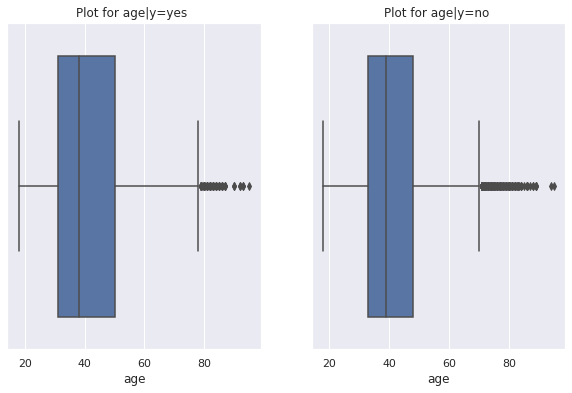

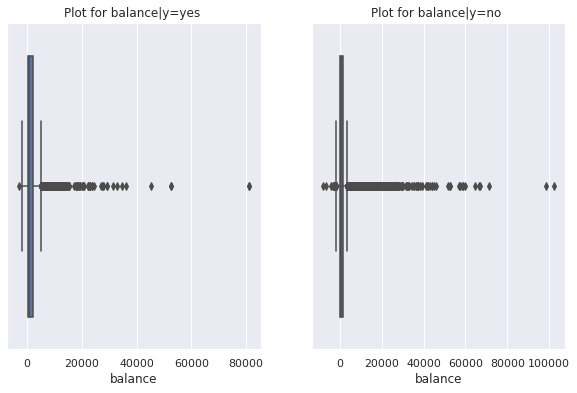

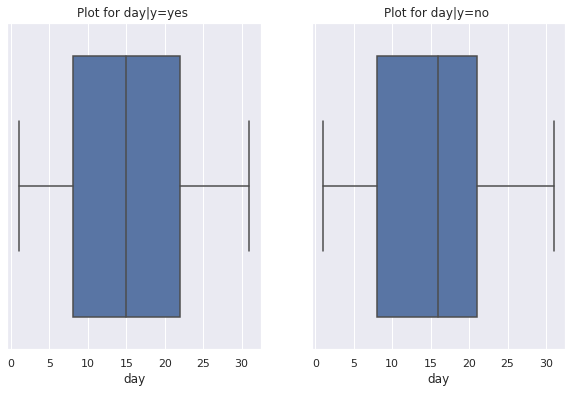

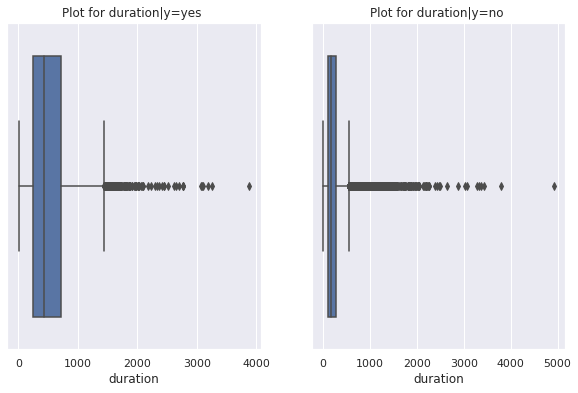

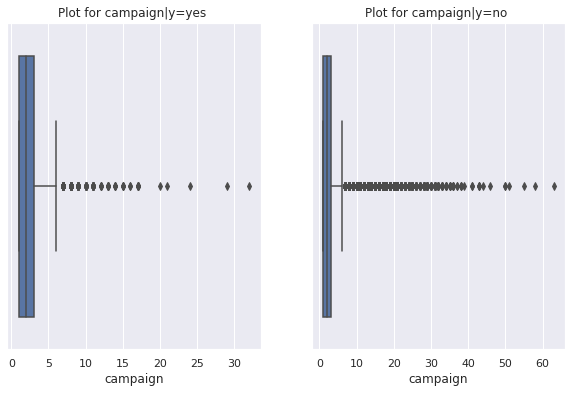

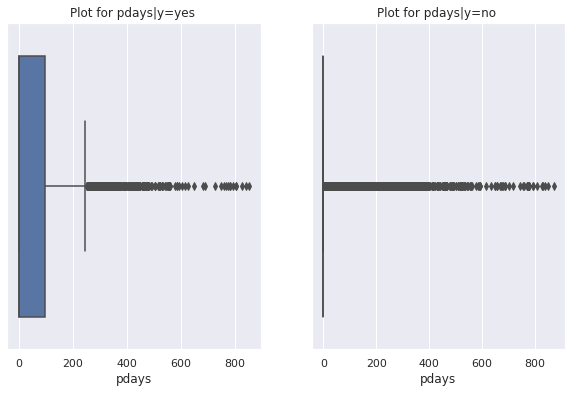

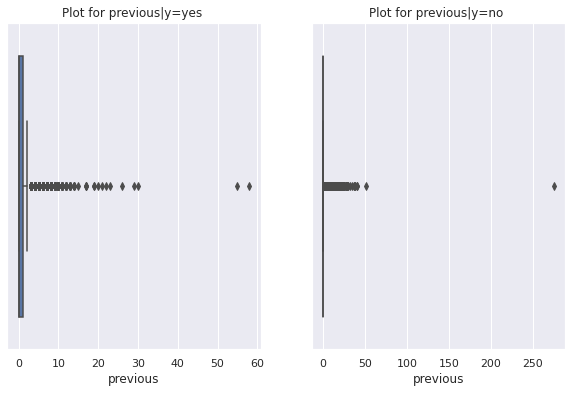

In [ ]:
for i,col in enumerate(list(df.describe().columns)):
  plt.figure(i)
  plt.subplot(1,2,1)
  sns.boxplot(df[df['y']=='yes'][col])
  plt.title(f'Plot for {col}|y=yes ')
  plt.subplot(1,2,2)
  sns.boxplot(df[df['y']=='no'][col])
  plt.title(f'Plot for {col}|y=no ')

In [ ]:
df['y'].replace({'no':0,'yes':1},inplace=True)

# **Day2: Feature Engineering**

In [ ]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


Changing the categorical Variables or Holding them for One hot Encoding

In [ ]:
one_hot_enc_cols = []

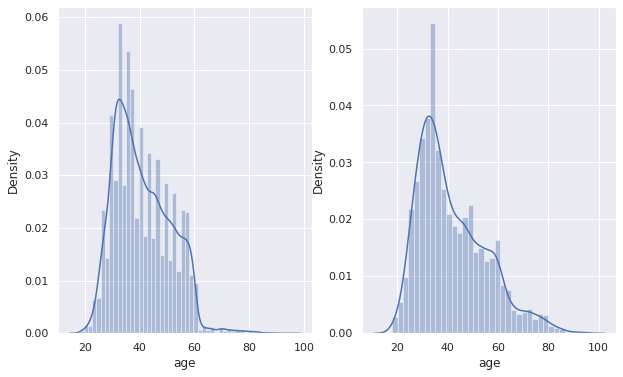

In [ ]:
#AGE
#we decided to categorise age in 4 bins by looking its distribution graphs
plt.subplot(1,2,1)
sns.distplot(df[df['y']==0]['age'])
plt.subplot(1,2,2)
sns.distplot(df[df['y']==1]['age'])

In [ ]:
def convert_age(age):
  if age<33:
    return 'struggling'
  elif age<45:
    return 'stable'
  elif age<60:
    return 'about_to_retire'
  elif age<67:
    return 'old_age'
  else:
    return 'counting_last_breaths'

In [ ]:
df['cat_age'] = df['age'].apply(convert_age)

In [ ]:
df['cat_age'].value_counts()

stable                   18436
about_to_retire          13880
struggling               11111
old_age                   1096
counting_last_breaths      688
Name: cat_age, dtype: int64

In [ ]:
one_hot_enc_cols.append('cat_age')

In [ ]:
#job
def cluster_jobs(job):
  new_cat1 = ['technician','services']
  new_cat2 = ['blue-collar','admin.']
  new_cat3 = ['self-employed','housemaid','entrepreneur']
  if job in new_cat1:
    return 'cat1'
  if job in new_cat2:
    return 'cat2'
  if job in new_cat3:
    return 'cat3'
  return job

In [ ]:
df['new_jobs'] = df['job'].apply(cluster_jobs)

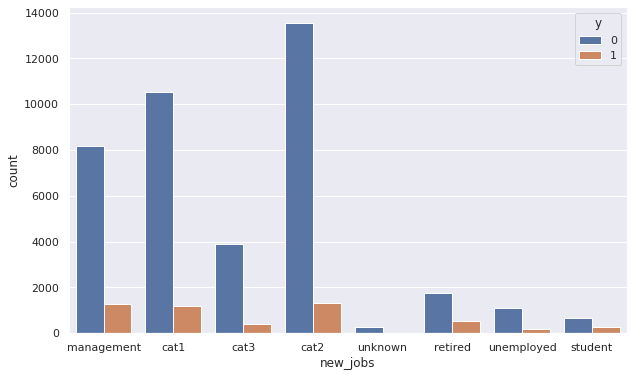

In [ ]:
sns.countplot(df['new_jobs'],hue=df['y'])

In [ ]:
one_hot_enc_cols.append('new_jobs')

A Fair Population

In [ ]:
#marital
one_hot_enc_cols.append('marital')

In [ ]:
#education
one_hot_enc_cols.append('education')

In [ ]:
#default
df.default.replace({'no':0,'yes':1},inplace=True)

In [ ]:
#balance
#will Scale Later

In [ ]:
#housing
df.housing.replace({'no':0,'yes':1},inplace=True)

In [ ]:
#loan default
df.loan.replace({'no':0,'yes':1},inplace=True)

In [ ]:
#contact
df.contact.replace({'unknown':0, 'cellular':1, 'telephone':1},inplace=True)

Decided to Drop Day, Month, Duration

In [ ]:
#poutcome
one_hot_enc_cols.append('poutcome')

In [ ]:
one_hot_enc_cols

['cat_age', 'new_jobs', 'marital', 'education', 'poutcome']

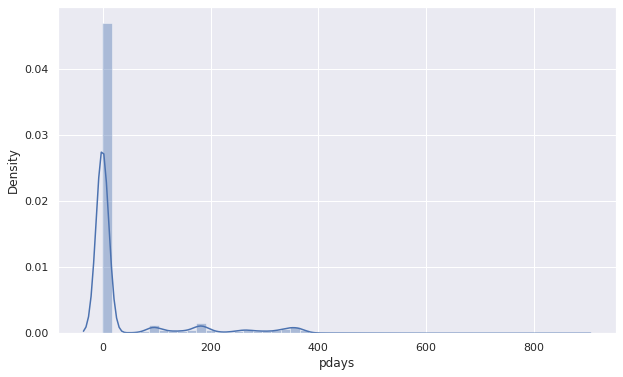

In [ ]:
sns.distplot(df['pdays'])

In [ ]:
#new Column
df['contacted_before']=df['pdays'].apply(lambda x : 1 if x!=-1 else 0 )

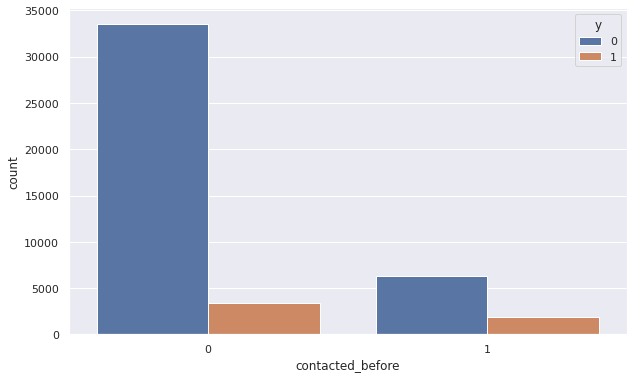

In [ ]:
sns.countplot(df['contacted_before'],hue = df['y'])

Let's check our new variable

In [ ]:
new_df = pd.get_dummies(df.drop(['age','job','pdays','day','month','duration'],axis=1),columns = one_hot_enc_cols)

In [ ]:
new_df.head()

,default,balance,housing,loan,contact,campaign,previous,y,contacted_before,cat_age_about_to_retire,cat_age_counting_last_breaths,cat_age_old_age,cat_age_stable,cat_age_struggling,new_jobs_cat1,new_jobs_cat2,new_jobs_cat3,new_jobs_management,new_jobs_retired,new_jobs_student,new_jobs_unemployed,new_jobs_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0,2143,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
1,0,29,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1
2,0,2,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
3,0,1506,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
4,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1


IQR

In [ ]:
# percentile_q1_balance = np.percentile(df['balance'],25)
# print(percentile_q1_balance)
# percentile_q2_balance = np.percentile(df['balance'],50)
# print(percentile_q2_balance)
# percentile_q3_balance = np.percentile(df['balance'],75)
# print(percentile_q3_balance)
# iqr=percentile_q3_balance - percentile_q1_balance
# lower_limit_outlier=percentile_q1_balance-1.5*iqr
# upper_limit_outlier=percentile_q3_balance+1.5*iqr
# print("lower limit for outlier  :",lower_limit_outlier)
# print("Upper limit for outlier  :",upper_limit_outlier)
# final_df=new_df[(new_df['balance']>lower_limit_outlier)&(new_df['balance']<upper_limit_outlier)]

ISOLATION Forest

In [ ]:
feature_df = new_df.drop(['y'],axis=1)
from sklearn.ensemble import IsolationForest
anomaly_filter = IsolationForest(contamination=0.1,n_jobs=-1)
anomalies = pd.Series(anomaly_filter.fit_predict(feature_df))
new_df['is_anomaly'] = anomalies
final_df = new_df[new_df['is_anomaly']==1].drop(['is_anomaly'],axis=1)

Scaling The Balance

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
final_df['balance'] = pd.Series(mms.fit_transform(final_df['balance'].values.reshape(-1,1)).flatten())

In [ ]:
final_df.shape

(40690, 33)

In [ ]:
final_df.head()

,default,balance,housing,loan,contact,campaign,previous,y,contacted_before,cat_age_about_to_retire,cat_age_counting_last_breaths,cat_age_old_age,cat_age_stable,cat_age_struggling,new_jobs_cat1,new_jobs_cat2,new_jobs_cat3,new_jobs_management,new_jobs_retired,new_jobs_student,new_jobs_unemployed,new_jobs_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0,0.092259,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
1,0,0.073067,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1
2,0,0.072822,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
3,0,0.086476,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
4,0,0.072812,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1


In [ ]:
for c in final_df.columns:
  print(final_df[c].value_counts())

0    40103
1      587
Name: default, dtype: int64
0.072803    3096
0.072812     169
0.072822     132
0.072840     123
0.072831     112
            ... 
0.140477       1
0.111198       1
0.369546       1
0.101111       1
0.000000       1
Name: balance, Length: 6784, dtype: int64
1    22987
0    17703
Name: housing, dtype: int64
0    34383
1     6307
Name: loan, dtype: int64
1    27948
0    12742
Name: contact, dtype: int64
1     15538
2     11372
3      4980
4      3253
5      1577
6      1169
7       654
8       494
9       307
10      250
11      181
12      147
13      127
14       89
15       81
16       73
17       63
18       44
19       42
20       37
21       34
23       20
25       20
22       19
24       19
28       15
26       11
29       11
31        8
32        8
30        7
27        7
33        6
34        5
43        3
38        3
36        3
35        3
41        2
50        2
39        1
37        1
46        1
51        1
55        1
44        1
Name: campaign, dtype:

In [ ]:
final_df =final_df[~final_df.isin([np.nan, np.inf, -np.inf]).any(1)]

OverSampling For Final DF

In [ ]:
from imblearn.over_sampling import SMOTE
sampler = SMOTE()
X,y = sampler.fit_resample(final_df.drop(['y'],axis=1).values,final_df['y'].values)

#  **Day3: Applying our Machine Learning Models**

1. LR
2. DT
3. RF
4. XGB
5. GBM
6. SVM
7. CatBoost
8. KNN
9. NN

In [ ]:
model_dict = {}

In [ ]:
# #Logistic Reg
# from sklearn.linear_model import LogisticRegression
# lr = LogisticRegression()
# params = {'C': [0.1,1.0,10], 'l1_ratio': [0.5], 'max_iter': [1000,10000], 'penalty': ['l2','l1','elasticnet'], 'solver': ['saga']}
# metric ='roc_auc'
# model_dict['Logistic Regression'] = [lr,params,metric]

# #random forest
# from sklearn.ensemble import RandomForestClassifier
# rf = RandomForestClassifier()
# params = {'criterion': ['gini','entropy'], 'max_depth': [5,10], 'min_samples_leaf': [10], 'n_estimators': [50,80,120]}
# metric = 'roc_auc'
# model_dict['Random Forest'] = [rf,params,metric]

# #XGB
# from xgboost import XGBClassifier
# xgb = XGBClassifier()
# params = {'learning_rate': [0.01,0.1,0.5], 'max_depth': [5,10], 'n_estimators': [50,80,120], 'reg_lambda': [0.1,1,10], 'seed': [123]}
# metric = 'roc_auc'
# model_dict['XG Boost'] = [xgb,params,metric]

# #SVM
# from sklearn.svm import SVC
# svc = SVC()
# params = {'C': [0.1,1.0,10], 'kernel': ['rbf','polynomial']}
# metric = 'roc_auc'
# model_dict['SVM'] = [svc,params,metric]



In [ ]:
gscv(model_dict,X,y)

,model,train_time,train_accuracy,train_precision,train_recall,train_f1_score,train_tn fp fn tp,train_auc_roc,test_accuracy,test_precision,test_recall,test_f1_score,test_tn fp fn tp,test_auc_roc
0,Random Forest,96.237520,0.770747,0.759238,0.790268,0.774442,"[21089, 6978, 5840, 22005]",0.770824,0.770353,0.764698,0.791408,0.777824,"[5149, 1729, 1481, 5619]",0.770014
1,XG Boost,1665.734655,0.936132,0.935049,0.936829,0.935938,"[26255, 1812, 1759, 26086]",0.936135,0.860280,0.868961,0.853662,0.861243,"[5964, 914, 1039, 6061]",0.860387
2,SVM,1962.665872,0.765882,0.769636,0.756258,0.762888,"[21764, 6303, 6787, 21058]",0.765844,0.764630,0.775528,0.755211,0.765235,"[5326, 1552, 1738, 5362]",0.764782


In [ ]:
sm.load()

{'Final Result':                  model   train_time  ...          test_tn fp fn tp  test_auc_roc
 0  Logistic Regression  1655.963176  ...  [4136, 2742, 2377, 4723]      0.633274
 
 [1 rows x 14 columns],
 'Logistic Regression': GridSearchCV(cv=5, error_score=nan,
              estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                           fit_intercept=True,
                                           intercept_scaling=1, l1_ratio=None,
                                           max_iter=100, multi_class='auto',
                                           n_jobs=None, penalty='l2',
                                           random_state=None, solver='lbfgs',
                                           tol=0.0001, verbose=0,
                                           warm_start=False),
              iid='deprecated', n_jobs=-1,
              param_grid={'C': [0.1, 1.0, 10], 'l1_ratio': [0.5],
                          'max_iter': [1000, 1000

In [ ]:
temp_res = sm.load('Final Result')

In [ ]:
sm.save(temp_res.append(sm.load('Final Result')),"Temp Result")

'Dumped Model Temp Result'

In [ ]:
sm.load('Temp Result')

,model,train_time,train_accuracy,train_precision,train_recall,train_f1_score,train_tn fp fn tp,train_auc_roc,test_accuracy,test_precision,test_recall,test_f1_score,test_tn fp fn tp,test_auc_roc
0,Logistic Regression,1655.963176,0.628595,0.619171,0.660442,0.639141,"[16756, 11311, 9455, 18390]",0.628721,0.633782,0.632686,0.665211,0.648541,"[4136, 2742, 2377, 4723]",0.633274
0,Random Forest,96.237520,0.770747,0.759238,0.790268,0.774442,"[21089, 6978, 5840, 22005]",0.770824,0.770353,0.764698,0.791408,0.777824,"[5149, 1729, 1481, 5619]",0.770014
1,XG Boost,1665.734655,0.936132,0.935049,0.936829,0.935938,"[26255, 1812, 1759, 26086]",0.936135,0.860280,0.868961,0.853662,0.861243,"[5964, 914, 1039, 6061]",0.860387
2,SVM,1962.665872,0.765882,0.769636,0.756258,0.762888,"[21764, 6303, 6787, 21058]",0.765844,0.764630,0.775528,0.755211,0.765235,"[5326, 1552, 1738, 5362]",0.764782


In [ ]:
!pip install shap

     |████████████████████████████████| 327kB 6.3MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463901 sha256=8ed80d70253a4d8087870a05ad5dabf0e0321ebd746768a93f5289e90d95f611
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


In [ ]:
model = sm.load('XG Boost').best_estimator_

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [ ]:
# load JS visualization code to notebook
shap.initjs()
i = 10
shap.force_plot(explainer.expected_value, shap_values[i], features=X[i], feature_names=list(final_df.drop(['y'],axis=1).columns))

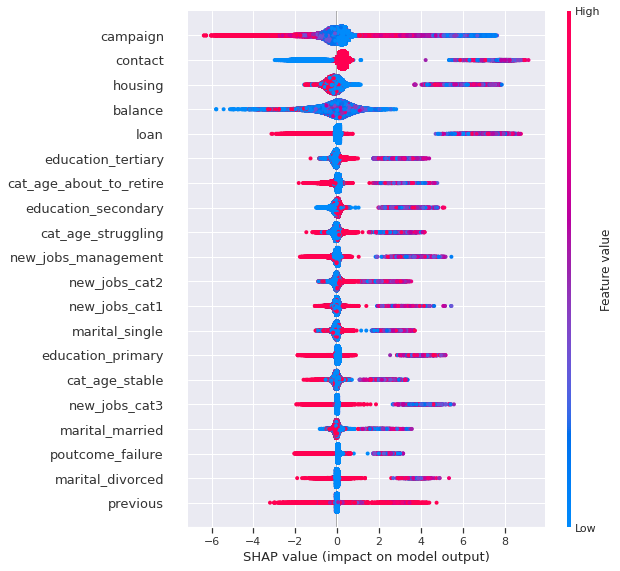

In [ ]:
shap.summary_plot(shap_values, features=X, feature_names=list(final_df.drop(['y'],axis=1).columns))

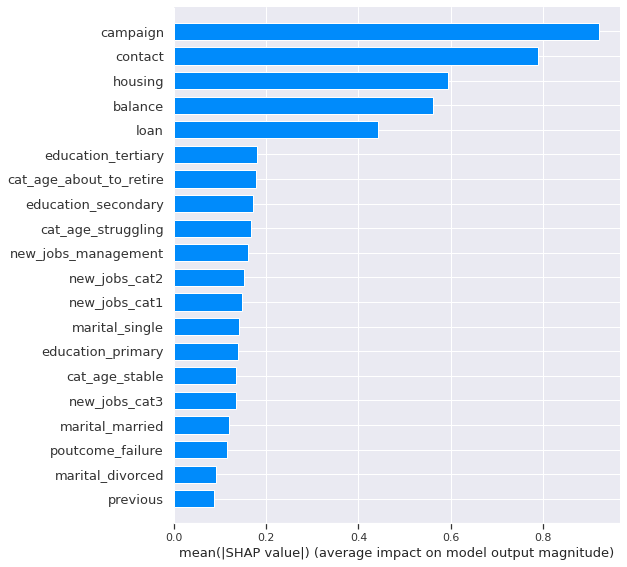

In [ ]:
shap.summary_plot(shap_values, features=X, feature_names=list(final_df.drop(['y'],axis=1).columns), plot_type='bar')

In [ ]:
import shap
def show_feature_importance():
  shap.initjs()
  model_df = sm.load("Final Result")
  models = model_df.model.unique()
  i=0
  for model in models:
    try:
      est = sm.load(model).best_estimator_
      explainer = shap.Explainer(est)
      shap_values = explainer.shap_values(X)
      plt.figure(i)
      shap.summary_plot(shap_values, features=X, feature_names=list(final_df.drop(['y'],axis=1).columns))
      plt.title(f"Feature importance for {model} ")
      plt.show()
      i+=1
      plt.figure(i)
      plt.title(f"Feature importance for {model} ")
      shap.summary_plot(shap_values, features=X, feature_names=list(final_df.drop(['y'],axis=1).columns), plot_type='bar')
      plt.show()
      i+=1
    except:
      continue

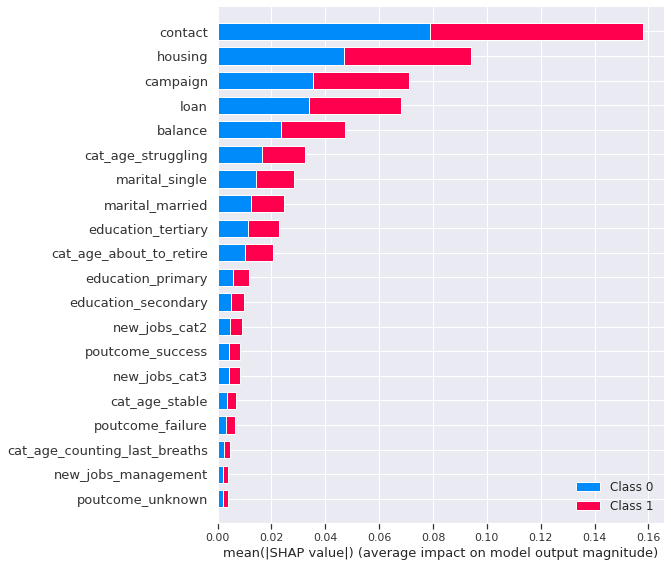

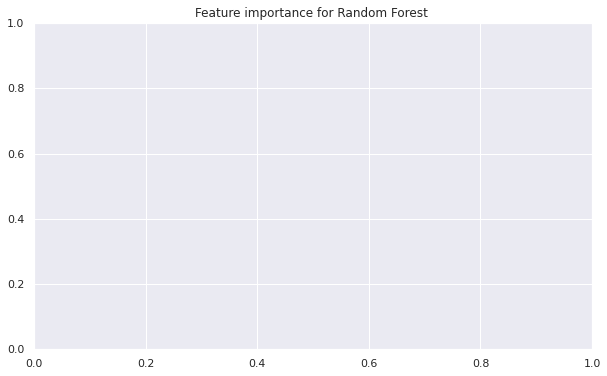

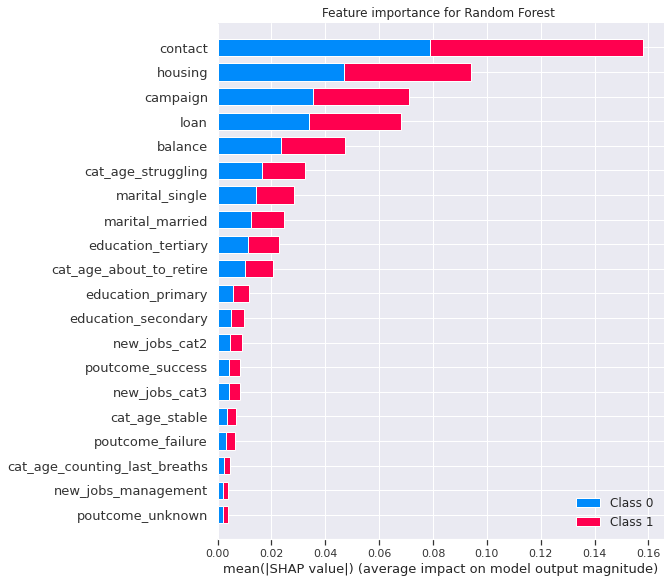

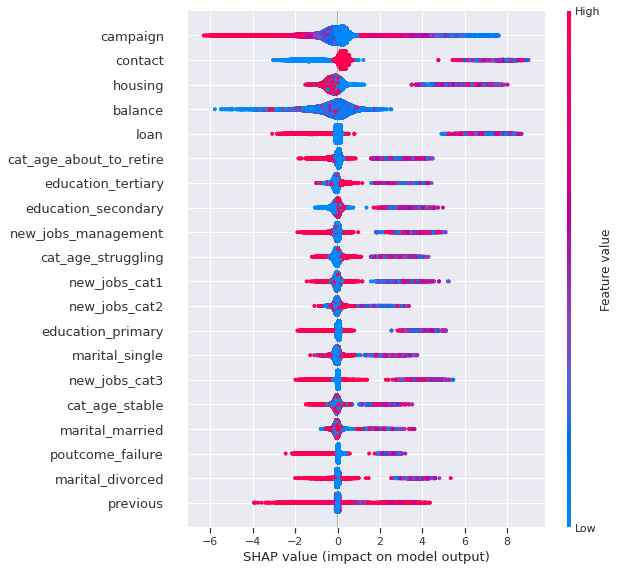

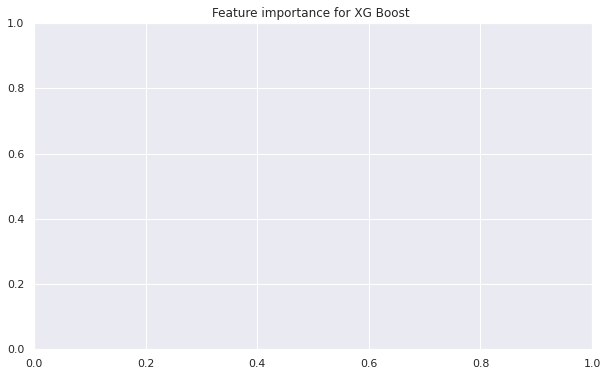

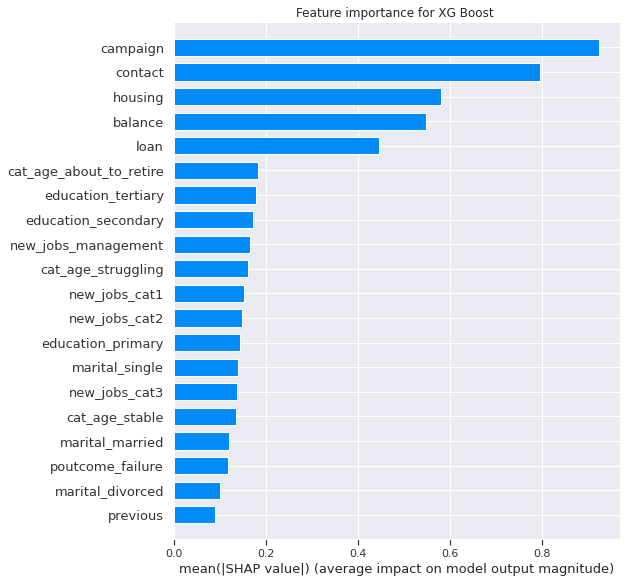

In [ ]:
show_feature_importance()

In [ ]:
for model in sm.load("Final Result").model.unique():
  est = sm.load(model).best_estimator_
  explainer = shap.Explainer(est)
  shap_values = explainer.shap_values(X)
  plt.figure(i)
  shap.summary_plot(shap_values, features=X, feature_names=list(final_df.drop(['y'],axis=1).columns))
  plt.title(f"Feature importance for {model} ")
  plt.show()
  i+=1
  plt.figure(i)
  plt.title(f"Feature importance for {model} ")
  shap.summary_plot(shap_values, features=X, feature_names=list(final_df.drop(['y'],axis=1).columns), plot_type='bar')
  plt.show()
  i+=1

NameError: ignored

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

def get_stacking(X,y):
  level0 = list()
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)
  for name in sm.load('Final Result').model.unique():
    level0.append((name, sm.load(name).best_estimator_))
	# define meta learner model
  level1 = LogisticRegression()
	# define the stacking ensemble
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
  model.fit(X_train,y_train)
  sm.save('Stacking',model)
  return model,X_test,y_test

In [ ]:
stack,valid_x,valid_y = get_stacking()

In [ ]:
stack.fit(X_train,y_train)